In [125]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mode

In [126]:
df = pd.read_excel('EquityIndexOptionsHistTrading-2021-2024.xlsx')

In [127]:
df

,Series,Trade Date,Open,High,Low,Close,Prior Settlement,Settlement,Change,%Change
0,S50F21C1000,2021-01-04,-,-,-,-,4.6,4.9,0.3,6.52
1,S50F21C1025,2021-01-04,-,-,-,-,2.4,2.5,0.1,4.17
2,S50F21C1050,2021-01-04,-,-,-,-,1.2,1.1,-0.1,-8.33
3,S50F21C650,2021-01-04,-,-,-,-,258.4,272.6,14.2,5.50
4,S50F21C675,2021-01-04,-,-,-,-,233.4,247.6,14.2,6.08
...,...,...,...,...,...,...,...,...,...,...
90327,S50M25P875,2024-12-30,18.5,19.5,18.4,19.5,21.5,19.5,-2.0,-9.30
90328,S50M25P900,2024-12-30,30,30,30,30,30.7,30.0,-0.7,-2.28
90329,S50M25P925,2024-12-30,-,-,-,-,44.5,45.1,0.6,1.35
90330,S50M25P950,2024-12-30,-,-,-,-,61.0,62.1,1.1,1.80


In [128]:
def get_otm_options(df, series_col='Series'):
    """
    Retrieves the 4 most out-of-the-money (OTM) options for each option series,
    distinguishing between calls and puts.

    Args:
        df (pd.DataFrame): Input DataFrame containing option data.
        series_col (str):  Name of the column containing option series.
                           Assumes the first 7 characters are the series, and
                           the 7th character indicates option type (C/P).

    Returns:
        pd.DataFrame: DataFrame containing the 4 most OTM options for each series.
    """

    def extract_strike_price(series_name):
        """Extracts the numeric strike price from the series name."""
        match = re.search(r'^.{7}(\D*)(\d+)$', series_name)
        if match:
            return int(match.group(2))
        else:
            return float('inf')

    df['StrikePrice'] = df[series_col].apply(extract_strike_price)
    df['Series7'] = df[series_col].str.slice(0, 7)
    df['OptionType'] = df[series_col].str[6].str.upper()  # Ensure 'C' or 'P'

    def get_otm_n_for_series(series_group):
        """Gets the n most OTM options for a series group."""
        if series_group['OptionType'].iloc[0] == 'C':
            return series_group.sort_values(by='StrikePrice', ascending=True).head(4)  # Lowest for Calls
        elif series_group['OptionType'].iloc[0] == 'P':
            return series_group.sort_values(by='StrikePrice', ascending=False).head(4) # Highest for Puts
        else:
            return pd.DataFrame()  # Return empty DataFrame for unknown type

    result_df = df.groupby(['Series7', 'OptionType']).apply(get_otm_n_for_series)

    return result_df.reset_index(level=[0, 1], drop=True)


# --- Example Usage ---

# Load the data from the Excel file
option_data = pd.read_excel('EquityIndexOptionsHistTrading-2021-2024.xlsx')

result_df = get_otm_options(option_data)
result_df = result_df[['Series', 'StrikePrice', 'OptionType']]  # Keep only relevant columns
result_df.reset_index(drop=True, inplace=True)  # Reset index
result_df

/var/folders/rc/w7r40l35143bxwkzfxdygctc0000gn/T/ipykernel_10771/998521248.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby(['Series7', 'OptionType']).apply(get_otm_n_for_series)


,Series,StrikePrice,OptionType
0,S50F21C650,650,C
1,S50F21C650,650,C
2,S50F21C650,650,C
3,S50F21C650,650,C
4,S50F21P1075,1075,P
...,...,...,...
411,S50Z24C700,700,C
412,S50Z24P1050,1050,P
413,S50Z24P1050,1050,P
414,S50Z24P1050,1050,P


In [129]:
hist = pd.read_csv('SET 50 Historical Data (5).csv')
hist['Date'] = pd.to_datetime(hist['Date'], format='%m/%d/%Y')
hist = hist[['Date', 'Price']]
hist.head(5)

,Date,Price
0,2024-12-30,906.23
1,2024-12-27,908.90
2,2024-12-26,906.41
3,2024-12-25,907.17
4,2024-12-24,904.44


In [130]:
endDate = pd.read_excel('SOMC Data SET Clear.xlsx', sheet_name='Option Series')
endDate['END_DATE'] = pd.to_datetime(endDate['END_DATE'], format='%Y%m%d')
endDate = endDate[['NAME', 'END_DATE']]
endDate

,NAME,END_DATE
0,S50K14C1000,2014-05-30
1,S50K14C825,2014-05-30
2,S50K14C850,2014-05-30
3,S50K14C875,2014-05-30
4,S50K14C900,2014-05-30
...,...,...
3179,S50N25P675,2025-07-31
3180,S50U25P875,2025-09-30
3181,S50U25C875,2025-09-30
3182,S50N25C875,2025-07-31


In [131]:
mer = result_df.merge(endDate, how='inner', left_on='Series', right_on='NAME', suffixes=('', '_y'))
mer = mer[['Series', 'OptionType', 'StrikePrice', 'END_DATE']]
finalDF = mer.merge(hist, how='inner', left_on='END_DATE', right_on='Date', suffixes=('', '_y'))
finalDF = finalDF[['Series', 'OptionType', 'END_DATE', 'StrikePrice', 'Price']]
finalDF = finalDF.drop_duplicates(subset=['Series', 'OptionType', 'END_DATE', 'StrikePrice', 'Price'])
finalDF.reset_index(drop=True, inplace=True)
finalDF

,Series,OptionType,END_DATE,StrikePrice,Price
0,S50F21C650,C,2021-01-29,650,916.66
1,S50F21P1075,P,2021-01-29,1075,916.66
2,S50F22C825,C,2022-01-31,825,993.29
3,S50F22P1100,P,2022-01-31,1100,993.29
4,S50F23C875,C,2023-01-31,875,992.95
...,...,...,...,...,...
99,S50Z23C750,C,2023-12-28,750,875.25
100,S50Z23P1075,P,2023-12-01,1075,852.94
101,S50Z23P1075,P,2023-12-28,1075,875.25
102,S50Z24C700,C,2024-12-30,700,906.23


In [132]:
finalDF['StrikePrice'] = finalDF['StrikePrice'].astype(float)
finalDF['Price'] = finalDF['Price'].str.replace(',', '', regex=False).astype(float)
finalDF['P/L'] = finalDF.apply(lambda row: max(row['Price'] - row['StrikePrice'], 0) 
                          if row['OptionType'] == 'C' 
                          else max(row['StrikePrice'] - row['Price'], 0), axis=1)
finalDF['P/L'] = finalDF['P/L'].round(2)
finalDF

,Series,OptionType,END_DATE,StrikePrice,Price,P/L
0,S50F21C650,C,2021-01-29,650.0,916.66,266.66
1,S50F21P1075,P,2021-01-29,1075.0,916.66,158.34
2,S50F22C825,C,2022-01-31,825.0,993.29,168.29
3,S50F22P1100,P,2022-01-31,1100.0,993.29,106.71
4,S50F23C875,C,2023-01-31,875.0,992.95,117.95
...,...,...,...,...,...,...
99,S50Z23C750,C,2023-12-28,750.0,875.25,125.25
100,S50Z23P1075,P,2023-12-01,1075.0,852.94,222.06
101,S50Z23P1075,P,2023-12-28,1075.0,875.25,199.75
102,S50Z24C700,C,2024-12-30,700.0,906.23,206.23


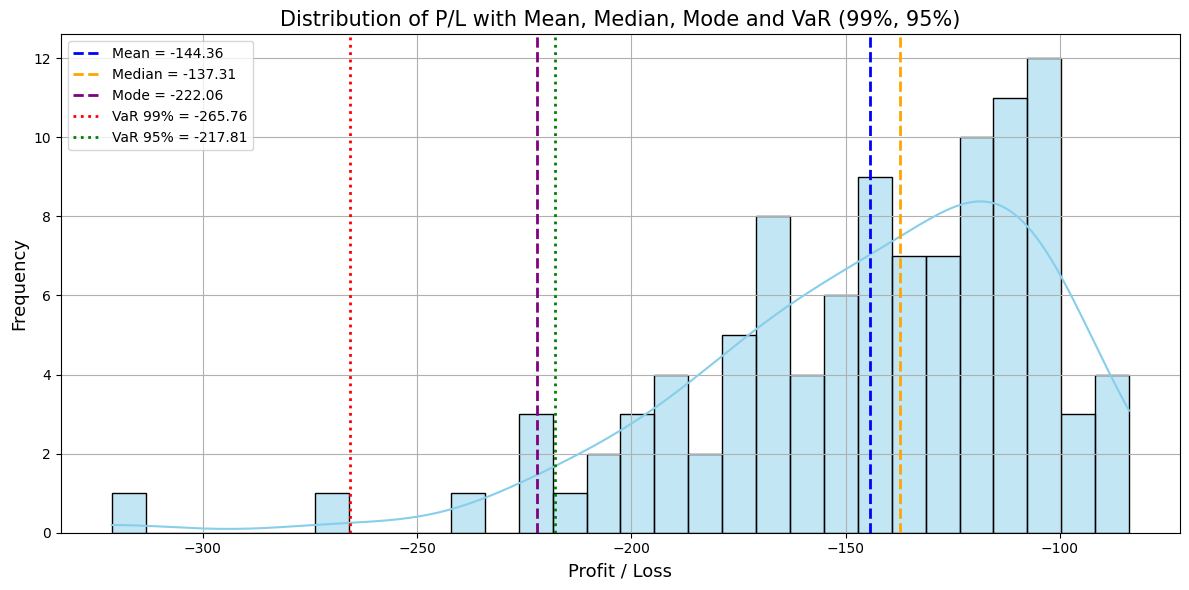

Mean: 	144.36
Median: 137.31
Mode: 	222.06
VaR 99%: 265.76
VaR 95%: 217.81


In [133]:
pl_data = -finalDF['P/L'].dropna()

mean_val = pl_data.mean()
median_val = pl_data.median()
mode_val = mode(pl_data, keepdims=True)[0][0]
var_99 = np.percentile(pl_data, 1)
var_95 = np.percentile(pl_data, 5)

plt.figure(figsize=(12, 6))
sns.histplot(pl_data, bins=30, kde=True, color='skyblue')

plt.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
plt.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median = {median_val:.2f}')
plt.axvline(mode_val, color='purple', linestyle='--', linewidth=2, label=f'Mode = {mode_val:.2f}')
plt.axvline(var_99, color='red', linestyle=':', linewidth=2, label=f'VaR 99% = {var_99:.2f}')
plt.axvline(var_95, color='green', linestyle=':', linewidth=2, label=f'VaR 95% = {var_95:.2f}')

plt.title('Distribution of P/L with Mean, Median, Mode and VaR (99%, 95%)', fontsize=15)
plt.xlabel('Profit / Loss', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Mean: \t{-mean_val:.2f}")
print(f"Median: {-median_val:.2f}")
print(f"Mode: \t{-mode_val:.2f}")
print(f"VaR 99%: {-var_99:.2f}")
print(f"VaR 95%: {-var_95:.2f}")


In [134]:
So = pd.read_excel('Historical Price Short Option Minimum Charge.xlsx')
So.drop(columns=['Date.1'], inplace=True)
So

,Date,Short Option Minimum Charge (Baht)
0,2021-01-04,260
1,2021-01-05,260
2,2021-01-06,260
3,2021-01-07,260
4,2021-01-08,260
...,...,...
964,2024-12-24,40
965,2024-12-25,40
966,2024-12-26,40
967,2024-12-27,40


In [135]:
So = So.rename(columns={'Short Option Minimum Charge  (Baht)': 'SOMC'})
So

,Date,SOMC
0,2021-01-04,260
1,2021-01-05,260
2,2021-01-06,260
3,2021-01-07,260
4,2021-01-08,260
...,...,...
964,2024-12-24,40
965,2024-12-25,40
966,2024-12-26,40
967,2024-12-27,40


In [136]:
somc_series = So.dropna().reset_index(drop=True)
somc_series['Date'] = pd.to_datetime(somc_series['Date'])
somc_series

,Date,SOMC
0,2021-01-04,260
1,2021-01-05,260
2,2021-01-06,260
3,2021-01-07,260
4,2021-01-08,260
...,...,...
964,2024-12-24,40
965,2024-12-25,40
966,2024-12-26,40
967,2024-12-27,40


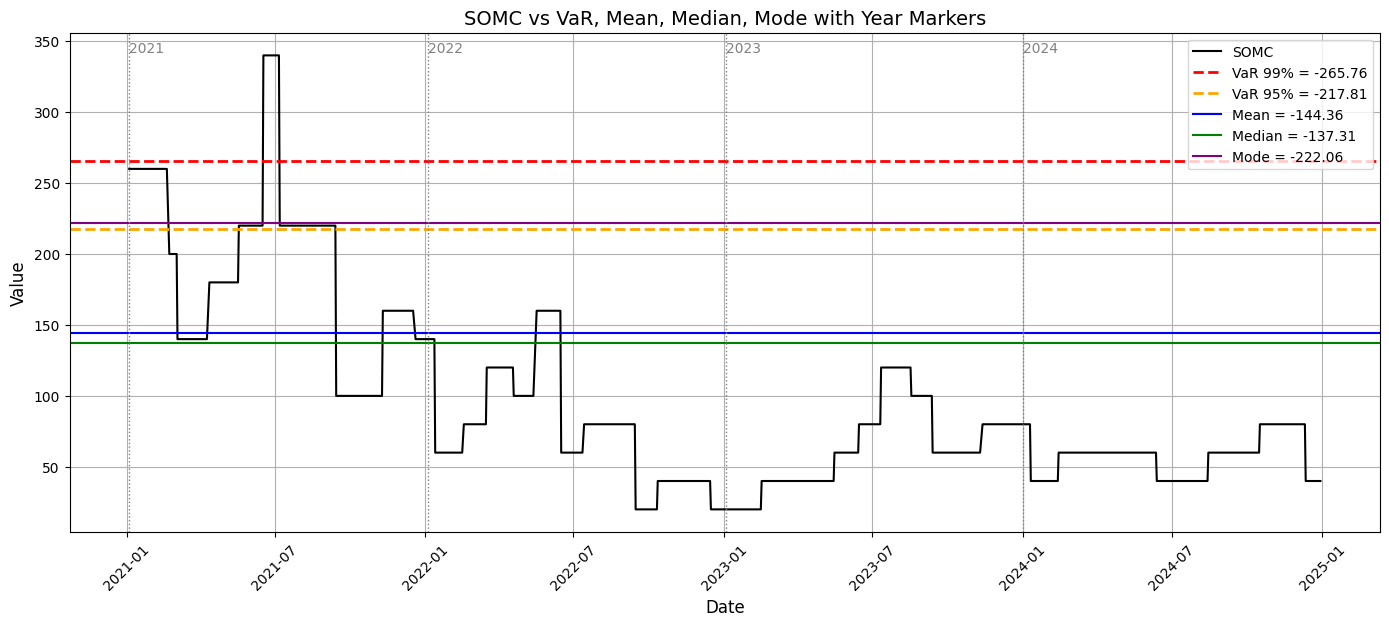

Mean: 	144.36
Median: 137.31
Mode: 	222.06
VaR 99%: 265.76
VaR 95%: 217.81


In [139]:
plt.figure(figsize=(14, 6))
plt.plot(somc_series['Date'], somc_series['SOMC'], label='SOMC', color='black')

# เส้น VaR
plt.axhline(y=-var_99, color='red', linestyle='--', linewidth=2, label=f'VaR 99% = {var_99:.2f}')
plt.axhline(y=-var_95, color='orange', linestyle='--', linewidth=2, label=f'VaR 95% = {var_95:.2f}')

# เส้นสถิติอื่น ๆ
plt.axhline(y=-mean_val, color='blue', linestyle='-', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
plt.axhline(y=-median_val, color='green', linestyle='-', linewidth=1.5, label=f'Median = {median_val:.2f}')
plt.axhline(y=-mode_val, color='purple', linestyle='-', linewidth=1.5, label=f'Mode = {mode_val:.2f}')

# เส้นแบ่งปี
years = somc_series['Date'].dt.year.unique()
for year in years:
    first_day = somc_series[somc_series['Date'].dt.year == year]['Date'].min()
    plt.axvline(x=first_day, color='gray', linestyle=':', linewidth=1)
    plt.text(first_day, somc_series['SOMC'].max(), str(year),
             verticalalignment='bottom', horizontalalignment='left', fontsize=10, color='gray')

# ตกแต่งกราฟ
plt.title("SOMC vs VaR, Mean, Median, Mode with Year Markers", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print(f"Mean: \t{-mean_val:.2f}")
print(f"Median: {-median_val:.2f}")
print(f"Mode: \t{-mode_val:.2f}")
print(f"VaR 99%: {-var_99:.2f}")
print(f"VaR 95%: {-var_95:.2f}")